In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re

from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

from sklearn.metrics import f1_score

In [2]:
train_df = pd.read_csv("/kaggle/input/persian-sentiment-analysis-snnapfood/train.csv", sep='\t', index_col="Unnamed: 0", on_bad_lines='skip')
dev_df = pd.read_csv("/kaggle/input/persian-sentiment-analysis-snnapfood/dev.csv", sep='\t', index_col="Unnamed: 0", on_bad_lines='skip')
test_df = pd.read_csv("/kaggle/input/persian-sentiment-analysis-snnapfood/test.csv", sep='\t', index_col="Unnamed: 0", on_bad_lines='skip')

In [3]:
class Vocabulary:
    def __init__(self, freq_threshold, max_size):
        """
        Initialize Vocabulary object.
        
        Args:
        - freq_threshold (int): Minimum frequency threshold for a word to be included in the vocabulary.
        - max_size (int): Maximum size of the vocabulary.
        """
        self.itos = {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>'}
        self.stoi = {k: j for j, k in self.itos.items()}
        self.freq_threshold = freq_threshold
        self.max_size = max_size

    def __len__(self):
        """
        Get the length of the vocabulary.
        """
        return len(self.itos)

    @staticmethod
    def tokenizer(text):
        """
        Tokenize the input text into individual words.
        
        Args:
        - text (str): Input text to tokenize.
        
        Returns:
        - list of str: List of tokenized words.
        """
        patterns = [
            (r'([a-zA-Z]+)', r' \1 '),                   
            (r'([\u0600-\u06FF]+)', r' \1 '),            
            (r'(?:[\d۰-۹]+(?:[.,/][\d۰-۹]+)?)', r' NUM '),  
            (r'([،؛؟»«!"#$%&()*+,-./:;<=>?@[\\\]^_`{|}~\t\n])\1*', r' \1 '), 
            (r'(\u200c)+', r' \1 '),                     
        ]
        
        for pattern, replacement in patterns:
            text = re.sub(pattern, replacement, text)
            
        return text.strip().split()

    def build_vocabulary(self, sentence_list):
        """
        Build the vocabulary based on the input list of sentences.
        
        Args:
        - sentence_list (list of str): List of sentences to build vocabulary from.
        """
        frequencies = Counter()
        for sentence in sentence_list:
            frequencies.update(self.tokenizer(sentence))

        frequencies = {k: v for k, v in frequencies.items() if v > self.freq_threshold}
        
        frequencies = dict(sorted(frequencies.items(), key=lambda x: -x[1])[:self.max_size - 4])

        idx = 4
        for word in frequencies:
            self.stoi[word] = idx
            self.itos[idx] = word
            idx += 1
            
    def get_vocabularies(self):
        """
        Get vocabularies.
        
        Returns:
        - tuple: Dictionaries itos.
        """
        return self.itos

    def numericalize(self, text):
        """
        Convert input text into a sequence of numerical indices based on the vocabulary.
        
        Args:
        - text (str): Input text to convert into numerical representation.
        
        Returns:
        - list of int: List of numerical indices representing the input text.
        """
        tokenized_text = self.tokenizer(text)
        numericalized_text = [self.stoi.get(token, self.stoi['<UNK>']) for token in tokenized_text]
        return numericalized_text

In [4]:
class CustomDataset(Dataset):
    """
    A custom PyTorch dataset class for loading data from a dataframe.

    Args:
        dataframe (pandas.DataFrame): The dataframe containing the data.
        text_col (str, optional): The name of the column containing text data. Default is 'comment'.
        label_col (str, optional): The name of the column containing label data. Default is 'label_id'.
        transform (callable, optional): Optional transform to be applied on a sample.
    """

    def __init__(self, dataframe, text_col='comment', label_col='label_id', transform=None):
        """
        Initializes the CustomDataset object.

        Args:
            dataframe (pandas.DataFrame): The dataframe containing the data.
            text_col (str, optional): The name of the column containing text data. Default is 'comment'.
            label_col (str, optional): The name of the column containing label data. Default is 'label_id'.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.dataframe = dataframe
        self.text_col = text_col
        self.label_col = label_col
        self.transform = transform

    def __len__(self):
        """
        Returns the length of the dataset.

        Returns:
            int: The length of the dataset.
        """
        return len(self.dataframe)

    def __getitem__(self, idx):
        """
        Retrieves a sample from the dataset at the given index.

        Args:
            idx (int): The index of the sample to retrieve.

        Returns:
            dict: A dictionary containing the text and label of the sample.
        """
        comment_of_sample = self.dataframe.iloc[idx][self.text_col]
        label_of_sample = self.dataframe.iloc[idx][self.label_col]
        sample = {'text': comment_of_sample , 'label': label_of_sample}

        if self.transform:
            sample = self.transform(sample)
        return sample

In [5]:
def collate_batch(batch, vocab):
    """
    Collates a batch of samples into padded sequences of text and labels.

    Args:
        batch (list): A list of samples, where each sample is a dictionary containing 'text' and 'label' keys.
        vocab (torchtext.vocab.Vocab): The vocabulary object used to numericalize text.

    Returns:
        tuple: A tuple containing three elements:
            - padded_text (torch.Tensor): Padded sequences of numericalized text.
            - label_list (torch.Tensor): Tensor containing labels for each sample.
            - lengths (torch.Tensor): Tensor containing lengths of sequences in the batch.
    """
    text_list, label_list, lengths = [], [], []
    for sample in batch:
        _text = sample["text"]
        _label = sample["label"]
        
        processed_text = torch.tensor(vocab.numericalize(_text), dtype=torch.int64)
        
        text_list.append(processed_text)
        label_list.append(float(_label))
        lengths.append(len(processed_text))
    
    padded_text = torch.nn.utils.rnn.pad_sequence(text_list, batch_first=True, padding_value=vocab.stoi['<PAD>'])
    
    return padded_text, torch.tensor(label_list), torch.tensor(lengths)

In [6]:
class RNN(nn.Module):
    """
    A recurrent neural network (RNN) model for sequence classification.

    Args:
        vocab_size (int): The size of the vocabulary.
        embed_dim (int): The dimensionality of the embedding layer.
        rnn_hidden_dim (int): The number of features in the RNN hidden state.
        fc_dim (int): The dimensionality of the fully connected layer.
        bidirectional (bool, optional): If True, use a bidirectional RNN. Default is True.
        num_layers (int, optional): Number of recurrent layers. Default is 2.
        dropout (float, optional): Dropout probability. Default is 0.25.
    """

    def __init__(self, vocab_size, embed_dim, rnn_hidden_dim, fc_dim, bidirectional=True, num_layers=2, dropout=0.5):
        """
        Initializes the RNN model.

        Args:
            vocab_size (int): The size of the vocabulary.
            embed_dim (int): The dimensionality of the embedding layer.
            rnn_hidden_dim (int): The number of features in the RNN hidden state.
            fc_dim (int): The dimensionality of the fully connected layer.
            bidirectional (bool, optional): If True, use a bidirectional RNN. Default is True.
            num_layers (int, optional): Number of recurrent layers. Default is 2.
            dropout (float, optional): Dropout probability. Default is 0.25.
        """
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.LSTM(embed_dim, rnn_hidden_dim, batch_first=True, bidirectional=bidirectional, num_layers=num_layers, dropout=dropout)
        self.fc1 = nn.Linear(rnn_hidden_dim * 2 if bidirectional else rnn_hidden_dim, fc_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, text, lengths):
        """
        Performs forward pass of the RNN model.

        Args:
            text (torch.Tensor): Input sequences of token indices.
            lengths (torch.Tensor): Lengths of sequences in the batch.

        Returns:
            torch.Tensor: Output predictions (probabilities).
        """
        out = self.embedding(text)
        out = nn.utils.rnn.pack_padded_sequence(out, lengths.cpu().numpy(), enforce_sorted=False, batch_first=True)
        _, (hidden, cell) = self.rnn(out)
        out = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1) if self.rnn.bidirectional else hidden[-1, :, :]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out


In [7]:
def train(dataloader):
    """
    Trains the model using the given dataloader.

    Args:
        dataloader (torch.utils.data.DataLoader): The dataloader providing batches of data.

    Returns:
        tuple: A tuple containing three elements:
            - avg_acc (float): Average accuracy of the model on the training data.
            - avg_loss (float): Average loss of the model on the training data.
            - f1 (float): F1 score of the model on the training data.
    """
    model.train()
    total_acc, total_loss = 0, 0
    y_true, y_pred = [], []
    for text_batch, label_batch, lengths in dataloader:
        text_batch, label_batch, lengths = text_batch.to(device), label_batch.to(device), lengths.to(device)
        optimizer.zero_grad()
        pred = model(text_batch, lengths)[:, 0]
        loss = criterion(pred, label_batch)
        loss.backward()
        optimizer.step()
        total_acc += ((pred >= 0.5).float() == label_batch).float().sum().item()
        total_loss += loss.item() * label_batch.size(0)
        y_true.extend(label_batch.cpu().numpy())
        y_pred.extend((pred >= 0.5).cpu().numpy())
    
    # Learning rate scheduling after each epoch
    scheduler.step()
    
    avg_acc = total_acc / len(dataloader.dataset)
    avg_loss = total_loss / len(dataloader.dataset)
    f1 = f1_score(y_true, y_pred)
    return avg_acc, avg_loss, f1

In [8]:
def evaluate(dataloader):
    """
    Evaluates the model using the given dataloader.

    Args:
        dataloader (torch.utils.data.DataLoader): The dataloader providing batches of data.

    Returns:
        tuple: A tuple containing three elements:
            - avg_acc (float): Average accuracy of the model on the validation data.
            - avg_loss (float): Average loss of the model on the validation data.
            - f1 (float): F1 score of the model on the validation data.
    """
    model.eval()
    total_acc, total_loss = 0, 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for text_batch, label_batch, lengths in dataloader:
            text_batch, label_batch, lengths = text_batch.to(device), label_batch.to(device), lengths.to(device)
            pred = model(text_batch, lengths)[:, 0]
            loss = criterion(pred, label_batch)
            total_acc += ((pred >= 0.5).float() == label_batch).float().sum().item()
            total_loss += loss.item() * label_batch.size(0)
            y_true.extend(label_batch.cpu().numpy())
            y_pred.extend((pred >= 0.5).cpu().numpy())
    avg_accuracy = total_acc / len(dataloader.dataset)
    average_loss = total_loss / len(dataloader.dataset)
    f1 = f1_score(y_true, y_pred)
    
    return avg_accuracy, average_loss, f1


In [9]:
vocab = Vocabulary(freq_threshold=5, max_size=10000)
vocab.build_vocabulary(train_df['comment'])

In [10]:
print(list(vocab.get_vocabularies().values())[:250])

['<PAD>', '<SOS>', '<EOS>', '<UNK>', 'بود', 'و', '.', '\u200c', 'به', 'از', 'که', 'خیلی', '،', 'هم', 'غذا', 'کیفیت', 'خوب', 'با', 'عالی', 'سفارش', 'شده', 'NUM', 'ولی', 'این', 'در', 'رو', 'من', 'نبود', 'بسیار', 'پیتزا', '!', 'رسید', 'واقعا', 'اصلا', 'سرد', 'خوشمزه', 'فقط', 'ارسال', 'ها', 'طعم', 'یک', 'مرغ', 'ممنون', 'کم', 'همیشه', 'تازه', 'بد', 'پیک', '…', 'یه', 'تا', 'مزه', 'برای', 'بودم', 'سیب', 'داشت', 'کاملا', 'اما', 'نداشت', 'تحویل', 'همه', 'بودن', 'بسته', 'سس', 'بی', 'نان', 'شد', 'مثل', 'قیمت', 'گرم', 'رستوران', 'زمینی', 'شیرینی', 'اینکه', 'متاسفانه', 'دادم', 'ساندویچ', 'حجم', 'اسنپ', 'دیگه', 'نسبت', 'تو', 'بندی', 'ای', 'های', 'می', 'داده', 'پایین', 'نون', 'ساعت', 'سلام', 'کیک', 'سریع', 'راضی', 'بار', 'کرده', 'پنیر', 'فود', 'سالاد', 'دو', 'زیاد', 'گوشت', 'موقع', 'را', 'باشه', 'بعد', 'مونده', 'بیشتر', 'کباب', 'نیست', 'دستم', 'کل', 'خشک', 'جوجه', 'مشتری', 'قبل', 'دقیقه', 'است', 'زمان', 'هست', 'کنید', '-', 'نه', 'ما', '؟', 'چیز', 'هر', 'برنج', 'میشه', 'خوبی', 'شما', 'فوق', 'قابل', 'م

In [11]:
train_dataset = CustomDataset(train_df)
validation_dataset = CustomDataset(dev_df)
test_dataset = CustomDataset(test_df)

In [12]:
batch_size = 64
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda batch: collate_batch(batch, vocab))
valid_dl = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda batch: collate_batch(batch, vocab))
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda batch: collate_batch(batch, vocab))

In [13]:
torch.manual_seed(1)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

vocab_size = len(vocab)  
embed_dim = 32  
rnn_hidden_dim = 8
fc_dim =  8

model = RNN(vocab_size, embed_dim, rnn_hidden_dim, fc_dim).to(device)

print(model)

cuda
RNN(
  (embedding): Embedding(5890, 32, padding_idx=0)
  (rnn): LSTM(32, 8, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc1): Linear(in_features=16, out_features=8, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [14]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [15]:
num_epochs = 5
torch.manual_seed(1)

train_acc_list, train_loss_list = [], []
valid_acc_list, valid_loss_list = [], []
train_f1_score_list, valid_f1_score_list = [], []

for epoch in tqdm(range(num_epochs)):
    acc_train, loss_train, f1_score_train = train(train_dl)
    acc_valid, loss_valid, f1_score_valid = evaluate(valid_dl)
    
    train_acc_list.append(acc_train)
    train_loss_list.append(loss_train)
    train_f1_score_list.append(f1_score_train)
    
    valid_acc_list.append(acc_valid)
    valid_loss_list.append(loss_valid)
    valid_f1_score_list.append(f1_score_valid)
    
    print(f'Epoch {epoch} *** acc_train: {acc_train:.4f} ****** acc_valid: {acc_valid:.4f}')
    print(f'Epoch {epoch} *** loss_train: {loss_train:.4f} ****** loss_valid: {loss_valid:.4f}')
    print(f'Epoch {epoch} *** f1_score_train: {f1_score_train:.4f} ****** f1_score_valid: {f1_score_valid:.4f}')        

 20%|██        | 1/5 [00:28<01:54, 28.55s/it]

Epoch 0 *** acc_train: 0.8324 ****** acc_valid: 0.8581
Epoch 0 *** loss_train: 0.3835 ****** loss_valid: 0.3355
Epoch 0 *** f1_score_train: 0.8406 ****** f1_score_valid: 0.8681


 40%|████      | 2/5 [00:56<01:24, 28.11s/it]

Epoch 1 *** acc_train: 0.8698 ****** acc_valid: 0.8605
Epoch 1 *** loss_train: 0.3145 ****** loss_valid: 0.3387
Epoch 1 *** f1_score_train: 0.8756 ****** f1_score_valid: 0.8688


 60%|██████    | 3/5 [01:23<00:55, 27.88s/it]

Epoch 2 *** acc_train: 0.8791 ****** acc_valid: 0.8611
Epoch 2 *** loss_train: 0.2915 ****** loss_valid: 0.3311
Epoch 2 *** f1_score_train: 0.8840 ****** f1_score_valid: 0.8694


 80%|████████  | 4/5 [01:51<00:27, 27.72s/it]

Epoch 3 *** acc_train: 0.8873 ****** acc_valid: 0.8548
Epoch 3 *** loss_train: 0.2733 ****** loss_valid: 0.3403
Epoch 3 *** f1_score_train: 0.8915 ****** f1_score_valid: 0.8629


100%|██████████| 5/5 [02:18<00:00, 27.78s/it]

Epoch 4 *** acc_train: 0.8934 ****** acc_valid: 0.8560
Epoch 4 *** loss_train: 0.2615 ****** loss_valid: 0.3521
Epoch 4 *** f1_score_train: 0.8971 ****** f1_score_valid: 0.8589


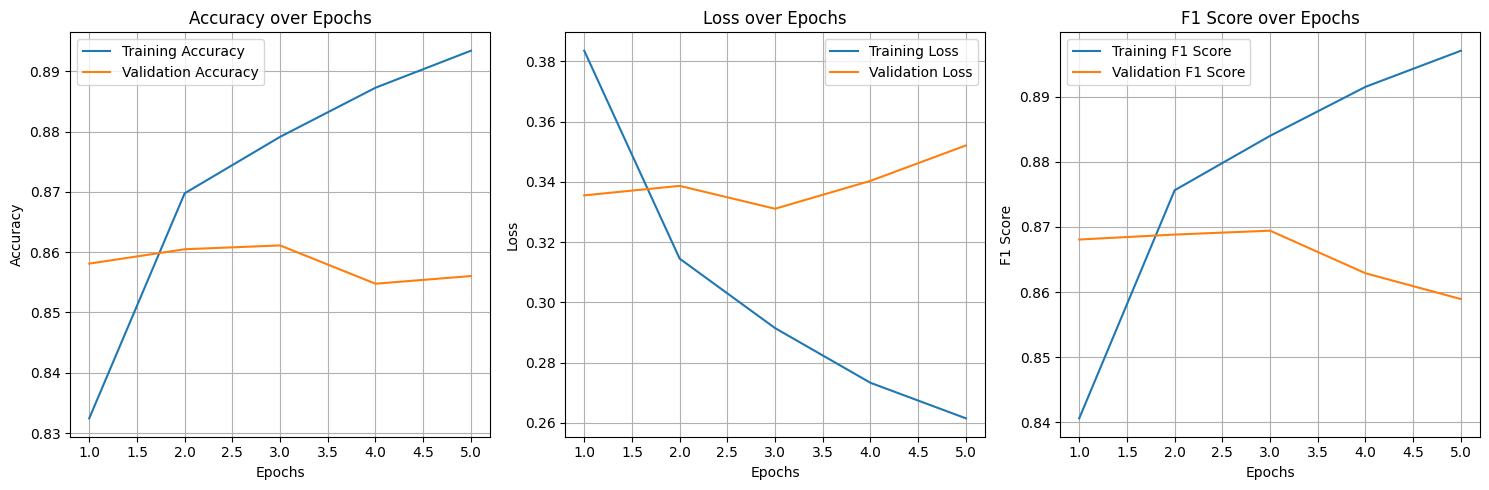

In [16]:
import matplotlib.pyplot as plt

def plot_metric(ax, epochs_range, train_values, valid_values, metric_name):
    """
    Plots a single metric (e.g., accuracy, loss, F1 score) over epochs.

    Args:
        ax (matplotlib.axes.Axes): The axes to plot on.
        epochs (list): List of epoch numbers.
        train_values (list): List of training values of the metric over epochs.
        valid_values (list): List of validation values of the metric over epochs.
        metric_name (str): Name of the metric (e.g., 'Accuracy', 'Loss', 'F1 Score').
    """
    ax.plot(epochs_range, train_values, label=f'Training {metric_name}')
    ax.plot(epochs_range, valid_values, label=f'Validation {metric_name}')
    ax.set_title(f'{metric_name} over Epochs')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(metric_name)
    ax.legend()
    ax.grid(True)

epochs = range(1, num_epochs + 1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

plot_metric(ax1, epochs, train_acc_list, valid_acc_list, 'Accuracy')
plot_metric(ax2, epochs, train_loss_list, valid_loss_list, 'Loss')
plot_metric(ax3, epochs, train_f1_score_list, valid_f1_score_list, 'F1 Score')

plt.tight_layout()
plt.show()


In [17]:
acc_test, _, f1_score_test = evaluate(test_dl)
print(f'acc_test: {acc_test:.4f} ****** f1_score_test: {f1_score_test:.4f}')

acc_test: 0.8569 ****** f1_score_test: 0.8582


In [18]:
torch.save(model, 'model.pth')